Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


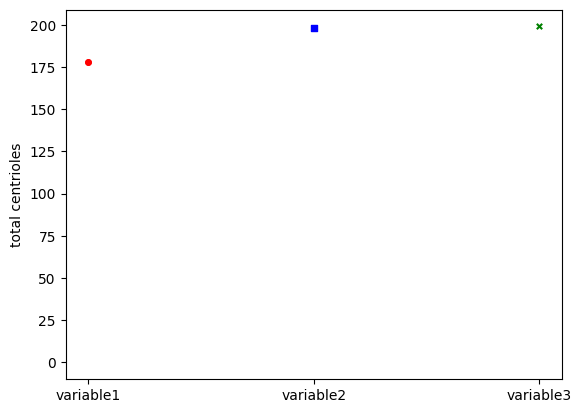

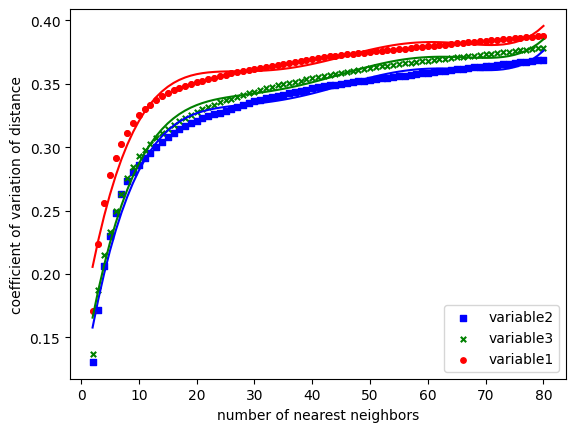

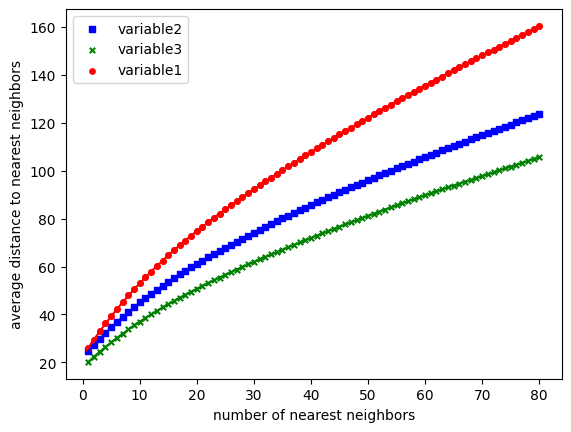

In [21]:
# Name all files that you want to use to start with "Variable1" "Variable2" or "Variable3" depending on content. Change this within variableNames
# If you only want to include 1 or 2 variables, set the remaining names to "null"

variableNames = ['Variable1', 'Variable2', 'null']

# Mark each method to indicate if it is run or not.
# First value is whether method is run or not; Mark as 'true' or 'false'
# Next two values are input and output paths respectively. The input can either be a file or folder
# Make sure file paths end with a '/' if it is a folder

centriolesInput = ['true', 'input path', 'save path']
variationInput = ['true', 'input path', 'save path']
distanceInput = ['true', 'input path', 'save path']

# Change xaxis to number of values to be calculated within the distance and variation functions
xaxis = 80

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

import math
import statistics
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import imutils
import scipy
from scipy.stats import variation
from os.path import exists
from google.colab import drive
drive.mount('/content/drive')

for a in range(len(variableNames)):
    variableNames[a] = variableNames[a].lower()

def findCenter(filepath):
    # open image
    im = cv2.imread(filepath)
    # set range to detect contours
    lower = np.array([254, 254, 254])
    upper = np.array([255, 255, 255])
    # create mask of contours in range
    shapeMask = cv2.inRange(im, lower, upper)
    boundary = cv2.findContours(shapeMask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundary = imutils.grab_contours(boundary)
    str1 = ""
    # get centroids for each contour
    for b in boundary:
        M = cv2.moments(b)

        bX = int(M["m10"] / M["m00"])
        bY = int(M["m01"] / M["m00"])
        # make list of centroid coordinates
        str1 += str(bX)+','+str(bY)+'\n'

        cv2.circle(im, (bX, bY), 1, (25, 25, 25), -1)

    return str1


def nearestNeighbor(num, xval, yval, im):
    # make a list from centroid coordinates
    with open(im) as f:
        mylist = [tuple(map(int, i.split(','))) for i in f]
    with open(im) as f:
        templen = [tuple(map(int, i.split(','))) for i in f]
    xylist = []
    results = [0]
    # find nearest num number of times
    for n in range(num):
        nearest = 99999
        #find distance to each point
        for x in mylist:
            temp = abs(math.sqrt((abs(xval-x[0])**2)+(abs(yval-x[1])**2)))
            # check if distance is the closest in the list so far
            if temp <= nearest and temp != 0:
                nearest = temp
        # add nearest neighbor after checking the whole list
        results.append(nearest)

        for x in mylist:
            temp = math.sqrt((abs(xval-x[0])**2)+(abs(yval-x[1])**2))
            if temp == nearest:
                # find the previous nearest and add the xy to a list
                for y in x:
                    xylist.append(y)
                # remove it from list so it is not found again
                mylist.remove(x)

    if len(results) > 0:
        # return results up to max number of values
        return results[1:len(templen)+1]


def allNearest(num, im):
    # open coordinates as a list
    with open(im) as f:
        mylist = [tuple(map(int, i.split(','))) for i in f]
    result = []
    # go through list and find nearestNeighbor for each coordinate
    for x in mylist:
        temp = nearestNeighbor(num, x[0], x[1], im)
        for y in temp:
        # get the result and return it
            result.append(y)
    return result


def averageLength(num, xval, yval, im):
    xsum = 0
    count = -1
    with open(im) as f:
        mylist = [tuple(map(int, i.split(','))) for i in f]
    xylist = []
    results = [0]
    tempp = [None] * num
    for n in range(len(tempp)):
        nearest = 99999
        # find nearest neighbor and add to result
        for x in mylist:
            temp = math.sqrt((abs(xval-x[0])**2)+(abs(yval-x[1])**2))
            if temp <= nearest and temp != 0:
                nearest = temp
        results.append(nearest)
        # remove the nearest neighbor from starting list
        for x in mylist:
            temp = math.sqrt((abs(xval-x[0])**2)+(abs(yval-x[1])**2))
            if temp == nearest:
                for y in x:
                    xylist.append(y)
                mylist.remove(x)

    for x in results:
        xsum += x
        count += 1
    # return average from results
    return xsum/count


def allAverageLength(num, im):
    xsum = 0
    count = 0
    with open(im) as f:
        mylist = [tuple(map(int, i.split(','))) for i in f]
    # get average length for each coordinate in list
    for x in mylist:
        xsum += averageLength(num, x[0], x[1], im)
        count += 1
    # return the average of all of the lengths
    return xsum/count


def coefficientOfVariation(num, im):
    sum = 0
    count = 0
    with open(im) as f:
                mylist1 = [tuple(map(int, i.split(','))) for i in f]
    for i in range(len(mylist1)):
        sum += statistics.stdev(nearestNeighbor(num, mylist1[i][0], mylist1[i][1], im)) / averageLength(num, mylist1[i][0], mylist1[i][1], im)
        count += 1

    return sum / count


def averageCoefficientOfVariation(num, im):
    return statistics.pstdev(allNearest(num, im)) / allAverageLength(num, im)


def showCentrioles(inputpath, savepath):

    if savepath.endswith('/'):
      savepath = savepath+'centrioles'

    dataSave = savepath+'_data.txt'

    savedData = open(dataSave, "w")
    savedData.write("Formatted as image name then number of centrioles \n")
    savedData = open(dataSave, "a")


    # make lists for each type of image used
    var1List = []
    var2List = []
    var3List = []
    # create a list of coordinates for each image that does not already have one
    directory = os.fsencode(inputpath)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".tif") and not(exists(inputpath+filename[:len(filename)-4]+'.txt')):
          print(str(inputpath)+str(filename))
          with open(inputpath+filename[:len(filename)-4]+'.txt', 'w') as f:
              f.write(findCenter(inputpath + filename))
    # run through each file in given folder and add the number of coordinates to a list
    for file in os.listdir(directory):
        filename = os.fsdecode(file)

        temp = inputpath + filename
        if filename.endswith(".txt"):
            tempbool = False
            with open(temp) as f:
                mylist1 = [tuple(map(int, i.split(','))) for i in f]
            if filename.lower().startswith(variableNames[0]):

                var1List.append(len(mylist1))
                tempbool = True
            if filename.lower().startswith(variableNames[1]):
                var2List.append(len(mylist1))
                tempbool = True
            if filename.lower().startswith(variableNames[2]):
                var3List.append(len(mylist1))
                tempbool = True
            if tempbool:
                savedData.write(" "+str(filename[:len(filename)-4])+".tif:  "+str(len(mylist1))+"\n")
    # plot data
    x = variableNames



    for a in var1List:
        plt.scatter(x[0], a, s=15, c='r', marker="o")
    for a in var2List:
        plt.scatter(x[1], a, s=15, c='b', marker="s")
    for a in var3List:
        plt.scatter(x[2], a, s=15, c='g', marker="x")
    temp = plt.scatter(x[0], 0, s=1, c='w', marker="o")
    plt.ylabel("total centrioles")
    plt.savefig(savepath+'_graph.png', dpi = 1440)
    plt.show()
    savedData.close()


def showDistance(inputpath, savepath):

    if savepath.endswith('/'):
      savepath = savepath+'distance'

    dataSave = savepath+'_data.txt'

    savedData = open(dataSave, "w")
    savedData.write("Formatted as image name, number of centrioles measured, average distance to that number of centrioles \n")
    savedData = open(dataSave, "a")

    # create array of x values
    x = []
    for a in range(xaxis):
      x.append(a+1)

    var1List = []
    var2List = []
    var3List = []
    v1Count = 0
    v2Count = 0
    v3Count = 0
    # loop through files in given folder
    directory = os.fsencode(inputpath)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        # find centroids for any image that does not have a associated coordinate list
        if filename.endswith(".tif") and not(exists(inputpath+filename[:len(filename)-4]+'.txt')):
          print(str(inputpath)+str(filename))
          with open(inputpath+filename[:len(filename)-4]+'.txt', 'w') as f:
              f.write(findCenter(inputpath + filename))

    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        temp = inputpath + filename
        # find all lists of coordinates and divide them into categories based on name

        if filename.endswith(".txt"):
            tempv = 0
            # graph data for each file
            with open(temp) as f:
                mylist1 = [tuple(map(int, i.split(','))) for i in f]
            if filename.lower().startswith(variableNames[0]):
                v1Count += xaxis
                count = -1
                v1List = []
                for a in x:
                    tempv += 1
                    aal = allAverageLength(a, temp)
                    var1List.insert(math.floor(v1Count/xaxis+count), aal)
                    v1List.append(aal)
                    savedData.write(str(filename)+": "+str(tempv)+", "+str(aal)+"\n")
                    count += v1Count/xaxis
                if v1Count == xaxis:
                  plt.scatter(x, v1List, s=15, c='r', marker="o", label=variableNames[0])
                else:
                  plt.scatter(x, v1List, s=15, c='r', marker="o")
            if filename.lower().startswith(variableNames[1]) :
                v2Count += xaxis
                v2List = []
                count = -1
                for a in x:
                    tempv += 1
                    aal = allAverageLength(a, temp)
                    v2List.append(aal)

                    savedData.write(str(filename)+": "+str(tempv)+", "+str(aal)+"\n")
                    var2List.insert(math.floor(v2Count/xaxis+count), aal)
                    count += v2Count/xaxis
                if v2Count == xaxis:
                  plt.scatter(x, v2List, s=15, c='b', marker="s", label=variableNames[1])
                else:
                  plt.scatter(x, v2List, s=15, c='b', marker="s")
            if filename.lower().startswith(variableNames[2]):
                v3Count += xaxis
                count = -1
                v3List = []
                for a in x:
                    tempv += 1
                    aal = allAverageLength(a, temp)
                    v3List.append(aal)

                    savedData.write(str(filename)+": "+str(tempv)+", "+str(aal)+"\n")
                    var3List.insert(math.floor(v3Count/xaxis+count), aal)
                    count += v3Count/xaxis
                if v3Count == xaxis:
                  plt.scatter(x, v3List, s=15, c='g', marker="x", label=variableNames[2])
                else:
                  plt.scatter(x, v3List, s=15, c='g', marker="x")
    # get new x value range for line of best fit

    var2Temp = []
    for i in range(v2Count):
      var2Temp.append(math.floor(i/(v2Count/xaxis))+1)

    var1Temp = []
    for i in range(v1Count):
      var1Temp.append(math.floor(i/(v1Count/xaxis))+1)

    var3Temp = []
    for i in range(v3Count):
      var3Temp.append(math.floor(i/(v3Count/xaxis))+1)

    # calculate and plot line of best fit
    plt.xlabel("number of nearest neighbors")
    plt.ylabel("average distance to nearest neighbors")
    if(variableNames[0]!='null'):
      plt.plot(np.unique(var1Temp), np.poly1d(np.polyfit(var1Temp, var1List, 5))(np.unique(var1Temp)), color="red")
    if(variableNames[1]!='null'):
      plt.plot(np.unique(var2Temp), np.poly1d(np.polyfit(var2Temp, var2List, 5))(np.unique(var2Temp)), color="blue")
    if(variableNames[2]!='null'):
      plt.plot(np.unique(var3Temp), np.poly1d(np.polyfit(var3Temp, var3List, 5))(np.unique(var3Temp)), color="green")
    plt.legend()
    plt.savefig(savepath+'_graph.png', dpi = 1440)
    plt.show()


def showVariation(inputpath, savepath):

    if savepath.endswith('/'):
      savepath = savepath+'variation'

    dataSave = savepath+'_data.txt'

    savedData = open(dataSave, "w")
    savedData.write("Formatted as image name, number of centrioles measured, variation of average distance to that number of centrioles \n")
    savedData = open(dataSave, "a")

    # create array of x values
    xaxis2 = xaxis - 1
    x = []
    for a in range(xaxis2):
      x.append(a+2)

    var1List = []
    var2List = []
    var3List = []
    v1Count = 0
    v2Count = 0
    v3Count = 0
    # loop through files in given folder
    directory = os.fsencode(inputpath)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        # find centroids for any image that does not have a associated coordinate list
        if filename.endswith(".tif") and not(exists(inputpath+filename[:len(filename)-4]+'.txt')):
          print(str(inputpath)+str(filename))
          with open(inputpath+filename[:len(filename)-4]+'.txt', 'w') as f:
              f.write(findCenter(inputpath + filename))

    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        temp = inputpath + filename
        # find all lists of coordinates and divide them into categories based on name
        if filename.endswith(".txt"):
            tempv = 1
            # graph data for each file
            with open(temp) as f:
                mylist1 = [tuple(map(int, i.split(','))) for i in f]
            if filename.lower().startswith(variableNames[0]):
                v1Count += xaxis2
                count = -1
                v1List = []
                for a in x:
                    tempv += 1
                    cov = coefficientOfVariation(a, temp)
                    var1List.insert(math.floor(v1Count/xaxis2+count), cov)
                    v1List.append(cov)
                    count+=v1Count/xaxis2
                    savedData.write(str(filename)+": "+str(tempv)+", "+str(cov)+"\n")
                if v1Count == xaxis2:
                  plt.scatter(x, v1List, s=15, c='r', marker="o", label=variableNames[0])
                else:
                  plt.scatter(x, v1List, s=15, c='r', marker="o")
            if filename.lower().startswith(variableNames[1]) :
                v2Count += xaxis2
                count = -1
                v2List = []
                for a in x:
                    tempv += 1
                    cov = coefficientOfVariation(a, temp)
                    v2List.append(cov)
                    var2List.insert(math.floor(v2Count/xaxis2+count), cov)
                    count+=v2Count/xaxis2
                    savedData.write(str(filename)+": "+str(tempv)+", "+str(cov)+"\n")
                if v2Count == xaxis2:
                  plt.scatter(x, v2List, s=15, c='b', marker="s", label=variableNames[1])
                else:
                  plt.scatter(x, v2List, s=15, c='b', marker="s")
            if filename.lower().startswith(variableNames[2]):
                v3Count += xaxis2
                count = -1
                v3List = []
                for a in x:
                    tempv += 1
                    cov = coefficientOfVariation(a, temp)
                    v3List.append(cov)
                    var3List.insert(math.floor(v3Count/xaxis2+count), cov)
                    count+=v3Count/xaxis2
                    savedData.write(str(filename)+": "+str(tempv)+", "+str(cov)+"\n")
                if v3Count == xaxis2:
                  plt.scatter(x, v3List, s=15, c='g', marker="x", label=variableNames[2])
                else:
                  plt.scatter(x, v3List, s=15, c='g', marker="x")
    # get new x value range for line of best fit

    var2Temp = []
    for i in range(v2Count):
      var2Temp.append(math.floor(i/(v2Count/xaxis2))+2)

    var1Temp = []
    for i in range(v1Count):
      var1Temp.append(math.floor(i/(v1Count/xaxis2))+2)

    var3Temp = []
    for i in range(v3Count):
      var3Temp.append(math.floor(i/(v3Count/xaxis2))+2)


    # calculate plot and line of best fit
    plt.xlabel("number of nearest neighbors")
    plt.ylabel("coefficient of variation of distance")
    if(variableNames[0]!='null'):
      plt.plot(np.unique(var1Temp), np.poly1d(np.polyfit(var1Temp, var1List, 5))(np.unique(var1Temp)), color="red")
    if(variableNames[1]!='null'):
      plt.plot(np.unique(var2Temp), np.poly1d(np.polyfit(var2Temp, var2List, 5))(np.unique(var2Temp)), color="blue")
    if(variableNames[2]!='null'):
      plt.plot(np.unique(var3Temp), np.poly1d(np.polyfit(var3Temp, var3List, 5))(np.unique(var3Temp)), color="green")
    plt.legend()
    plt.savefig(savepath+'_graph.png', dpi = 1440)
    plt.show()


if __name__ == '__main__':
    # call methods here using filepath to folder of images
    # folders have to end with '/'
    # save path can be either folder or name
    if(centriolesInput[0]=='true'):
      showCentrioles(centriolesInput[1],centriolesInput[2])
    if(variationInput[0]=='true'):
      showVariation(variationInput[1],variationInput[2])
    if(distanceInput[0].lower()=='true'):
      showDistance(distanceInput[1],distanceInput[2])
    #showCentrioles(inputpath, savepath)
    #showVariation(inputpath, savepath)
    #showDistance(inputpath, savepath)


